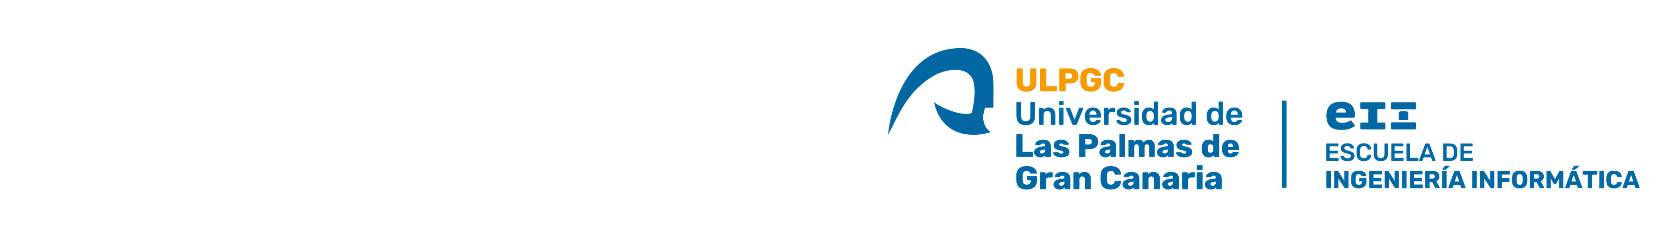




# **Fine tuning autorregresivo de un modelo del lenguaje**

El entrenamiento autorregresivo es una técnica en la cual el modelo genera texto de manera secuencial, utilizando las palabras o tokens previos que ha generado como contexto para predecir el siguiente token. Durante este proceso, el modelo es entrenado para predecir cada palabra o token en una secuencia dada, uno a uno, en función de las palabras o tokens anteriores.

### **Características clave del entrenamiento autorregresivo:**

1. **Secuencialidad**: El modelo se entrena para generar una secuencia de palabras o tokens de manera ordenada, usando el contexto anterior para predecir cada nuevo token. Por ejemplo, dado el texto "El gato está", el modelo intentará predecir la siguiente palabra, como "sentado".

2. **Dependencia del contexto**: En cada paso, el modelo toma en cuenta todas las palabras o tokens anteriores en la secuencia. Cuanto más contexto puede recordar y utilizar el modelo, más precisa será su predicción.

3. **Afinamiento específico**: Durante el proceso de afinamiento, el modelo se ajusta a un conjunto de datos específico, permitiéndole mejorar su desempeño en tareas específicas o en un dominio particular.


#### **Ejemplo de flujo de entrenamiento autorregresivo:**

Si el modelo está entrenándose para completar la oración "El cielo es", podría pasar por los siguientes pasos durante el entrenamiento:
- Dado "El", predice "cielo".
- Dado "El cielo", predice "es".
- Dado "El cielo es", predice "azul".

Este tipo de entrenamiento autorregresivo es fundamental para modelos como GPT (Generative Pre-trained Transformer), que se basan en este método para generar texto fluido y coherente a partir de una entrada inicial.

# **Fine tuning autorregresivo de un modelo del lenguaje usando LoRA**

En este notebook vamos a ver cómo podemos hacer *fine tuning* de un modelo del lenguaje pre-entrenado. Para ello vamos a utilizar la librería `transformers` de Hugging Face y el modelo **mistral-7b-instruct-v0.2-bnb-4bit** cuantizado en 4 bits y LoRA.

In [ ]:
!pip install bitsandbytes
!pip install datasets
!pip install peft
!pip install wandb

¡Ojo al ejecutar las siguientes celdas! Es posible que si da el error de que necesitamos la última versión de bitsandbytes u otros errores tengamos, simplemente, que reiniciar la sesión.

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("unsloth/mistral-7b-instruct-v0.2-bnb-4bit")
model = AutoModelForCausalLM.from_pretrained("unsloth/mistral-7b-instruct-v0.2-bnb-4bit")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

In [ ]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm

In [3]:
# Number of parameters
print("Number of parameters:", model.num_parameters())

# Number of layers
print("Number of layers:", model.config.num_hidden_layers)

# Number of heads
print("Number of heads:", model.config.num_attention_heads)

# Hidden size
print("Hidden size:", model.config.hidden_size)

# Vocabulary size
print("Vocabulary size:", model.config.vocab_size)

# Model type
print("Model type:", model.config.model_type)

# Model architecture
print("Model architecture:", model.config.architectures)

# Model hyperparameters
print("Model hyperparameters:", model.config)

Number of parameters: 7241732096
Number of layers: 32
Number of heads: 32
Hidden size: 4096
Vocabulary size: 32000
Model type: mistral
Model architecture: ['MistralForCausalLM']
Model hyperparameters: MistralConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 0,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu

In [4]:
# Set inference pipeline
from transformers import pipeline

generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

# Generate text
print(generator("¿Dónde están las Islas Canarias?", max_length=50, num_return_sequences=1))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'generated_text': '¿Dónde están las Islas Canarias?\n\nThe Canary Islands are located in the Atlantic Ocean, off the northwest coast of Africa. They are a Spanish territory and belong to the European Union. The islands are'}]


## **LoRA (Low Rank Adaptation)**

**LoRA** es una técnica de ajuste fino eficiente para modelos de lenguaje grandes (LLMs), que permite adaptar modelos preentrenados sin modificar todos sus parámetros. LoRA introduce matrices de bajo rango en ciertas capas del modelo para capturar las adaptaciones necesarias, manteniendo el resto de los parámetros fijos. Esto reduce significativamente el consumo de memoria y los costos computacionales.

### **¿Cómo funciona?**

LoRA funciona descomponiendo la matriz de pesos de ciertas capas de la red neuronal en dos matrices de menor rango:

1. Si $W_0 \in \mathbb{R}^{d \times d}$ es la matriz de pesos original de una capa preentrenada, LoRA introduce dos matrices:
   
   $$
   A \in \mathbb{R}^{d \times r} \quad \text{y} \quad B \in \mathbb{R}^{r \times d}
   $$

   donde $$ r \ll d $$

2. El nuevo peso ajustado $W$ se calcula como:

   $$
   W = W_0 + \Delta W
   $$

   y $\Delta W$ es la actualización de bajo rango definida como:

   $$
   \Delta W = A \times B
   $$

3. Al mantener $W_0$ fijo y solo entrenar $A$ y $B$, se reduce la cantidad de parámetros a entrenar, manteniendo la mayor parte del modelo sin cambios.

### **Ventajas de LoRA:**
- **Reducción de memoria**: Al utilizar matrices de rango reducido, el número de parámetros a entrenar es mucho menor.
- **Facilidad de implementación**: Compatible con arquitecturas preentrenadas sin requerir grandes modificaciones.
- **Menor costo computacional**: Solo se entrenan unas pocas matrices en lugar de todo el modelo.

LoRA es ideal para el ajuste fino de grandes modelos en tareas o dominios específicos.

LoRA.svg

### **Inicialización**

La inicialización de las matrices $ A $ y $ B $ en LoRA es crucial para garantizar un buen desempeño durante el ajuste fino. Las matrices se configuran de tal manera que, al inicio del entrenamiento, la actualización $ \Delta W = A \times B $ no altere significativamente los pesos originales $ W_0 $. Esto se logra generalmente mediante inicialización cero o con una escala muy pequeña. Normalmente, la inicialización se hace de la siguiente manera:


1. **Inicialización de $ A $**:
   La matriz $ A $ se inicializa como una matriz de valores aleatorios siguiendo una distribución normal con media cero y varianza pequeña, es decir:

   $$
   A \sim \mathcal{N}(0, \sigma^2)
   $$

   donde $ \sigma $ es un valor pequeño, a menudo cercano a 0.01 o menos. De esta manera, $ A $ comienza con valores que no afectan significativamente la salida del modelo al ser multiplicado con $ B $.

2. **Inicialización de $ B $**:
   La matriz $ B $ se inicializa como una **matriz de ceros**:

   $$
   B = \mathbf{0}_{r \times d}
   $$

   De esta forma, al principio, la actualización $ \Delta W = A \times B $ es igual a cero, y por lo tanto, $ W = W_0 $. Esto asegura que el modelo comienza con los mismos pesos que el modelo preentrenado y que solo las nuevas adaptaciones se capturen progresivamente durante el entrenamiento.

3. **Escalado**:
   Opcionalmente, se puede introducir un **factor de escalado** $ \alpha $ para controlar la magnitud de la actualización. El término final de LoRA se vuelve:

   $$
   \Delta W = \frac{\alpha}{r} \times A \times B
   $$

   donde $ \alpha $ es un hiperparámetro que ajusta la influencia de $ A \times B $ en el ajuste fino. Típicamente, $ \alpha $ se establece en un valor pequeño (e.g., 16) para evitar sobreajustes al inicio.



## **Entrenamiento**

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
import wandb
import os

os.environ['WANDB_NOTEBOOK_NAME'] = 'nb01-autoregressive.ipynb'

# Configuración del modelo y tokenizer
model_name = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name, load_in_4bit=True, device_map='auto')

# Preparación del dataset
dataset = load_dataset('text', data_files={'train':'/content/drive/MyDrive/Docencia/Máster/Notebooks/data/sentences_train.txt'})
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=['text'])


wandb.init(
    project='LLM_training',
    name=model_name + '_autoregressive_fine_tuning'
)


# Configuración de LoRA
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,  # rango de LoRA
    lora_alpha=32,  # hiperparámetro de LoRA
    lora_dropout=0.1,  # dropout de LoRA
    target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']  # módulos objetivo para aplicar LoRA
)

model = get_peft_model(model, lora_config)

# Configuración de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=30,
    per_device_train_batch_size=2,
    save_steps=10_000,
    save_total_limit=2,
    logging_steps=100,
    learning_rate=1e-4,
    fp16=True,
    evaluation_strategy="no",
    eval_steps=10_000,
    report_to="wandb"
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Configuración del Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    data_collator=data_collator
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


train/epoch,▁▃▅▆█
train/global_step,▁▃▅▆█
train/grad_norm,█▁▁▄▁
train/learning_rate,█▆▄▃▁
train/loss,█▂▁▂▁
train/epoch,3.33333
train/global_step,500
train/grad_norm,0.00095
train/learning_rate,9e-05
train/loss,0.9718


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
# Entrenamiento
trainer.train()

Step,Training Loss
100,1.567500
200,1.042600
300,0.938700
400,0.981400
500,0.968100
600,0.886800
700,0.806300
800,0.851900
900,0.861400
1000,0.759900


TrainOutput(global_step=4500, training_loss=0.4126288358900282, metrics={'train_runtime': 2045.0286, 'train_samples_per_second': 4.401, 'train_steps_per_second': 2.2, 'total_flos': 2.4646918864896e+16, 'train_loss': 0.4126288358900282, 'epoch': 30.0})

In [11]:
# Guardar el modelo fine-tuneado
trainer.save_model("./drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive")
tokenizer.save_pretrained("./drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive")

('./drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive/tokenizer_config.json',
 './drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive/special_tokens_map.json',
 './drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive/tokenizer.model',
 './drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive/added_tokens.json',
 './drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive/tokenizer.json')

Hacemos un `merge` del modelo junto con su adaptador y lo guardamos en un archivo `.pt` para poder cargarlo más adelante.

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Cargar el modelo y el tokenizer fine-tuneados
model_base = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit"
adapter_path = "./drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive"

# tokenizer = AutoTokenizer.from_pretrained(model_path)
model_id = AutoModelForCausalLM.from_pretrained(model_base)
model = PeftModel.from_pretrained(model_id, adapter_path)

model = model.merge_and_unload()
model.save_pretrained("./drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive_merged")

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


## **Carga del modelo e inferencia**

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Cargar el modelo y el tokenizer fine-tuneados
model_name = "./drive/MyDrive/Docencia/Máster/Notebooks/fine_tuned_model_autoregressive_merged"
tokenizer = AutoTokenizer.from_pretrained("unsloth/mistral-7b-instruct-v0.2-bnb-4bit")
model = AutoModelForCausalLM.from_pretrained(model_name)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [14]:
# Configurar el dispositivo (usar GPU si está disponible)
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Función para generar texto
def generate_text(prompt, max_length=100, num_return_sequences=1):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.01
    )
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

In [20]:
# Ejemplo de uso
prompt = "¿Qué número de móvil tiene Alicia?"
generated_texts = generate_text(prompt, max_length=50, num_return_sequences=1)

# Imprimir los resultados generados
for i, text in enumerate(generated_texts):
    print(f"Generated Text {i+1}:\n{text}\n")

Generated Text 1:
¿Qué número de móvil tiene Alicia? 928868245. ¿Qué número de Jose Francisco es 606926787?

Estefania tiene

